In [ ]:
!pip install -q ultralytics opencv-python matplotlib numpy pillow torch torchvision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 27.2 MB/s eta 0:00:00


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
from ultralytics import YOLO

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [ ]:
# Load YOLOv8 pretrained on COCO
model = YOLO("yolov8n.pt")

In [ ]:
from google.colab import files

uploaded = files.upload()
image_path = list(uploaded.keys())[0]

Saving brown-beer-bottle-7370424.webp to brown-beer-bottle-7370424.webp



image 1/1 /content/brown-beer-bottle-7370424.webp: 640x352 1 vase, 111.1ms
Speed: 12.2ms preprocess, 111.1ms inference, 42.4ms postprocess per image at shape (1, 3, 640, 352)


array([[[254, 254, 254],
        [254, 254, 254],
        [254, 254, 254],
        ...,
        [254, 254, 254],
        [254, 254, 254],
        [254, 254, 254]],

       [[254, 254, 254],
        [254, 254, 254],
        [254, 254, 254],
        ...,
        [254, 254, 254],
        [254, 254, 254],
        [254, 254, 254]],

       [[254, 254, 254],
        [254, 254, 254],
        [254, 254, 254],
        ...,
        [254, 254, 254],
        [254, 254, 254],
        [254, 254, 254]],

       ...,

       [[254, 254, 254],
        [254, 254, 254],
        [254, 254, 254],
        ...,
        [254, 254, 254],
        [254, 254, 254],
        [254, 254, 254]],

       [[254, 254, 254],
        [254, 254, 254],
        [254, 254, 254],
        ...,
        [254, 254, 254],
        [254, 254, 254],
        [254, 254, 254]],

       [[254, 254, 254],
        [254, 254, 254],
        [254, 254, 254],
        ...,
        [254, 254, 254],
        [254, 254, 254],
        [254, 254, 254]]], dtype=uint8)
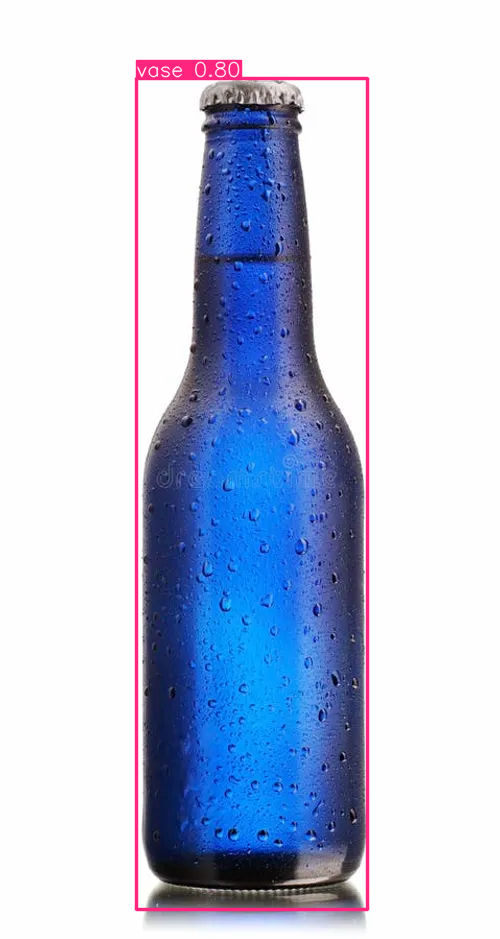

In [ ]:
results = model(image_path)

# Show detection result
results[0].plot()

In [ ]:
img = cv2.imread(image_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

bottle_crops = []

ACCEPTED_CLASSES = ["bottle", "vase"]

for box in results[0].boxes:
    cls_id = int(box.cls[0])
    label = model.names[cls_id]

    if label in ACCEPTED_CLASSES:
        x1, y1, x2, y2 = map(int, box.xyxy[0])
        crop = img[y1:y2, x1:x2]
        bottle_crops.append(crop)

print(f"Detected bottle-like objects: {len(bottle_crops)}")

Detected bottle-like objects: 1


In [ ]:
if len(bottle_crops) == 0:
    raise ValueError("No bottle-like object detected. Try another image.")

In [ ]:
sample_crop = bottle_crops[0]
features = extract_features(sample_crop)
print("Feature map shape:", features.shape)

Feature map shape: torch.Size([1, 512, 8, 8])


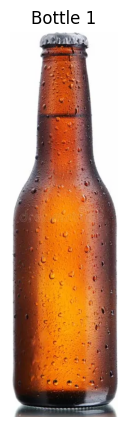

In [ ]:
for i, crop in enumerate(bottle_crops):
    plt.figure(figsize=(3,5))
    plt.imshow(crop)
    plt.title(f"Bottle {i+1}")
    plt.axis("off")
    plt.show()

In [ ]:
import torchvision.transforms as transforms

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

In [ ]:
from torchvision.models import resnet18

backbone = resnet18(pretrained=True)
backbone.eval()

# Remove classifier head
backbone = torch.nn.Sequential(*list(backbone.children())[:-2])

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 105MB/s]


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
backbone.to(device)

def extract_features(img_crop):
    img_tensor = transform(img_crop).unsqueeze(0).to(device)
    with torch.no_grad():
        features = backbone(img_tensor)
    return features

In [ ]:
sample_crop = bottle_crops[0]
features = extract_features(sample_crop)

print("Feature map shape:", features.shape)

Feature map shape: torch.Size([1, 512, 8, 8])


In [ ]:
# For now, bottole is treated as "normal reference"
normal_features = extract_features(sample_crop)

In [ ]:
def compute_anomaly_map(test_feat, ref_feat):
    # L2 distance per spatial location
    diff = torch.norm(test_feat - ref_feat, dim=1)
    anomaly_map = diff.squeeze().cpu().numpy()
    return anomaly_map

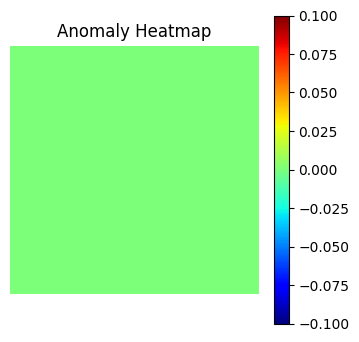

In [ ]:
test_features = extract_features(sample_crop)
anomaly_map = compute_anomaly_map(test_features, normal_features)

plt.figure(figsize=(4,4))
plt.imshow(anomaly_map, cmap="jet")
plt.colorbar()
plt.title("Anomaly Heatmap")
plt.axis("off")
plt.show()

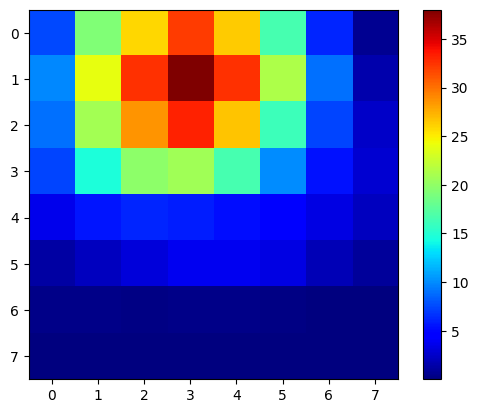

In [ ]:
noisy_crop = sample_crop.copy()
noisy_crop[50:120, 50:120] = 0  # simulate defect

test_features = extract_features(noisy_crop)
anomaly_map = compute_anomaly_map(test_features, normal_features)

plt.imshow(anomaly_map, cmap="jet")
plt.colorbar()
plt.show()

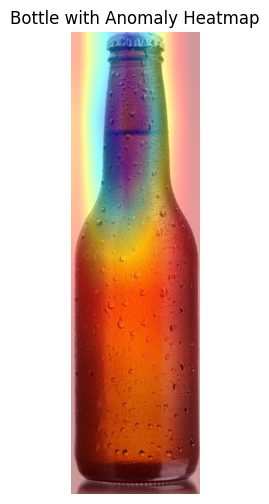

In [ ]:
import cv2

heatmap_resized = cv2.resize(anomaly_map, (sample_crop.shape[1], sample_crop.shape[0]))
heatmap_norm = (heatmap_resized - heatmap_resized.min()) / (heatmap_resized.max() - heatmap_resized.min())

heatmap_color = cv2.applyColorMap(
    (heatmap_norm * 255).astype(np.uint8),
    cv2.COLORMAP_JET
)

overlay = cv2.addWeighted(sample_crop, 0.6, heatmap_color, 0.4, 0)

plt.figure(figsize=(4,6))
plt.imshow(overlay)
plt.title("Bottle with Anomaly Heatmap")
plt.axis("off")
plt.show()

In [ ]:
anomaly_score = anomaly_map.max()
print(f"Anomaly Score: {anomaly_score:.4f}")

Anomaly Score: 38.0137


In [ ]:
!pip install -q kaggle

In [ ]:
import os
os.environ["KAGGLE_API_TOKEN"] = "KGAT_574300132082c3cae00812e614526948"

In [ ]:
import json
import os

kaggle_dict = {
    "username": "arkapravaroyit27",
    "key": "KGAT_574300132082c3cae00812e614526948"
}

os.makedirs("/root/.kaggle", exist_ok=True)

with open("/root/.kaggle/kaggle.json", "w") as f:
    json.dump(kaggle_dict, f)

!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d ipythonx/mvtec-ad
!unzip mvtec-ad.zip

In [ ]:
ls bottle/train/good | head

000.png
001.png
002.png
003.png
004.png
005.png
006.png
007.png
008.png
009.png


In [ ]:
from google.colab import files
uploaded = files.upload()
web_image_paths = list(uploaded.keys())

Saving brown-beer-bottle-7370424.webp to brown-beer-bottle-7370424 (1).webp


In [ ]:
import os
from tqdm import tqdm

normal_feature_bank = []

# 1️⃣ MVTec normal bottles
mvtec_path = "bottle/train/good"

for img_name in tqdm(os.listdir(mvtec_path)):
    img_path = os.path.join(mvtec_path, img_name)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    feat = extract_features(img)
    normal_feature_bank.append(feat)

# 2️⃣ Web / phone bottle images
for img_path in tqdm(web_image_paths):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    feat = extract_features(img)
    normal_feature_bank.append(feat)

print(f"Normal feature samples collected: {len(normal_feature_bank)}")

100%|██████████| 1/1 [00:00<00:00, 32.87it/s]

Normal feature samples collected: 210


In [ ]:
def compute_anomaly_map_with_memory(test_feat, memory_bank):
    distances = []

    for ref_feat in memory_bank:
        diff = torch.norm(test_feat - ref_feat, dim=1)
        distances.append(diff)

    distances = torch.stack(distances)
    anomaly_map = distances.min(dim=0)[0]  # nearest neighbor distance

    return anomaly_map.squeeze().cpu().numpy()

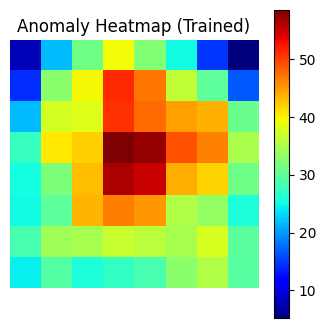

In [ ]:
test_features = extract_features(sample_crop)

anomaly_map = compute_anomaly_map_with_memory(
    test_features, normal_feature_bank
)

plt.figure(figsize=(4,4))
plt.imshow(anomaly_map, cmap="jet")
plt.colorbar()
plt.title("Anomaly Heatmap (Trained)")
plt.axis("off")
plt.show()

In [ ]:
compute_anomaly_map_with_memory

<function __main__.compute_anomaly_map_with_memory(test_feat, memory_bank)>

In [ ]:
# Simple threshold (we will tune this later)
THRESHOLD = 40.0

anomaly_score = anomaly_map.max()

if anomaly_score > THRESHOLD:
    status = "ANOMALOUS"
else:
    status = "NORMAL"

print(f"Anomaly Score: {anomaly_score:.2f}")
print(f"Status: {status}")

Anomaly Score: 58.53
Status: ANOMALOUS


In [ ]:
def detect_and_analyze_bottles(
    image_path,
    yolo_model,
    backbone,
    normal_feature_bank,
    threshold=40.0
):
    """
    Full pipeline:
    image -> detect bottles -> anomaly score + heatmap per bottle
    """

    # Load image
    img_bgr = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

    # Run detection
    results = yolo_model(image_path)

    outputs = []

    ACCEPTED_CLASSES = ["bottle", "vase"]

    for box in results[0].boxes:
        cls_id = int(box.cls[0])
        label = yolo_model.names[cls_id]

        if label not in ACCEPTED_CLASSES:
            continue

        x1, y1, x2, y2 = map(int, box.xyxy[0])
        crop = img_rgb[y1:y2, x1:x2]

        if crop.size == 0:
            continue

        # Feature extraction
        test_features = extract_features(crop)

        # Anomaly map
        anomaly_map = compute_anomaly_map_with_memory(
            test_features, normal_feature_bank
        )

        anomaly_score = anomaly_map.max()
        status = "ANOMALOUS" if anomaly_score > threshold else "NORMAL"

        # Heatmap overlay
        heatmap_resized = cv2.resize(
            anomaly_map, (crop.shape[1], crop.shape[0])
        )
        heatmap_norm = (
            heatmap_resized - heatmap_resized.min()
        ) / (heatmap_resized.max() - heatmap_resized.min() + 1e-6)

        heatmap_color = cv2.applyColorMap(
            (heatmap_norm * 255).astype(np.uint8),
            cv2.COLORMAP_JET
        )

        overlay = cv2.addWeighted(crop, 0.6, heatmap_color, 0.4, 0)

        outputs.append({
            "bbox": (x1, y1, x2, y2),
            "label": label,
            "score": float(anomaly_score),
            "status": status,
            "overlay": overlay
        })

    return img_rgb, outputs

In [ ]:
image_rgb, results = detect_and_analyze_bottles(
    image_path=image_path,
    yolo_model=model,
    backbone=backbone,
    normal_feature_bank=normal_feature_bank,
    threshold=40.0
)

print(f"Detected bottle-like objects: {len(results)}")


image 1/1 /content/brown-beer-bottle-7370424.webp: 640x352 1 vase, 40.7ms
Speed: 10.4ms preprocess, 40.7ms inference, 16.0ms postprocess per image at shape (1, 3, 640, 352)
Detected bottle-like objects: 1


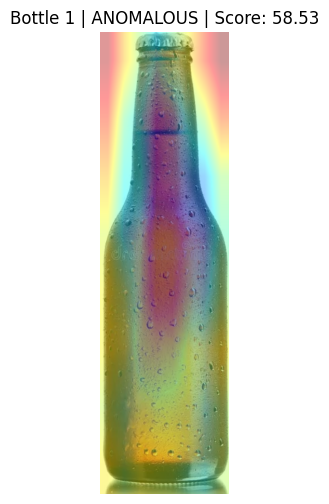

In [ ]:
for i, res in enumerate(results):
    plt.figure(figsize=(4,6))
    plt.imshow(res["overlay"])
    plt.title(
        f"Bottle {i+1} | {res['status']} | Score: {res['score']:.2f}"
    )
    plt.axis("off")
    plt.show()

In [ ]:
normal_scores = []

for feat in normal_feature_bank:
    # compare normal feature against normal memory
    anomaly_map = compute_anomaly_map_with_memory(
        feat, normal_feature_bank
    )
    normal_scores.append(anomaly_map.max())

normal_scores = np.array(normal_scores)

# Auto threshold: 95th percentile
AUTO_THRESHOLD = np.percentile(normal_scores, 95)

print(f"Auto Threshold (95th percentile): {AUTO_THRESHOLD:.2f}")

Auto Threshold (95th percentile): 0.00


In [ ]:
def compute_confidence(score, threshold):
    if score <= threshold:
        return (1 - score / threshold) * 100
    else:
        return min((score - threshold) / threshold * 100, 100)

In [ ]:
def extract_defect_regions(anomaly_map, threshold_ratio=0.6):
    """
    threshold_ratio: fraction of max anomaly to consider defect
    """
    thresh_val = threshold_ratio * anomaly_map.max()
    mask = anomaly_map > thresh_val

    mask = mask.astype(np.uint8) * 255

    contours, _ = cv2.findContours(
        mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
    )

    regions = []
    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        area = w * h
        regions.append((x, y, w, h, area))

    return regions

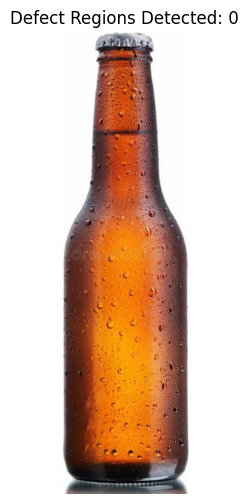

In [ ]:
regions = extract_defect_regions(anomaly_map)

overlay_defects = sample_crop.copy()

for (x, y, w, h, area) in regions:
    cv2.rectangle(
        overlay_defects,
        (x, y),
        (x + w, y + h),
        (255, 0, 0),
        2
    )

plt.figure(figsize=(4,6))
plt.imshow(overlay_defects)
plt.title(f"Defect Regions Detected: {len(regions)}")
plt.axis("off")
plt.show()

In [ ]:
confidence = compute_confidence(anomaly_score, AUTO_THRESHOLD)
status = "ANOMALOUS" if anomaly_score > AUTO_THRESHOLD else "NORMAL"

/tmp/ipython-input-2632959768.py:5: RuntimeWarning: divide by zero encountered in scalar divide
  return min((score - threshold) / threshold * 100, 100)


In [ ]:
regions = extract_defect_regions(anomaly_map)

In [ ]:
def compute_confidence(score, threshold):
    if threshold <= 1e-6:
        return 0.0

    if score <= threshold:
        return max((1 - score / threshold) * 100, 0)
    else:
        return min((score - threshold) / threshold * 100, 100)

In [ ]:
def detect_and_analyze_bottles(
    image_path,
    yolo_model,
    backbone,
    normal_feature_bank,
    threshold
):
    img_bgr = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

    results = yolo_model(image_path)
    outputs = []

    ACCEPTED_CLASSES = ["bottle", "vase"]

    for box in results[0].boxes:
        cls_id = int(box.cls[0])
        label = yolo_model.names[cls_id]

        if label not in ACCEPTED_CLASSES:
            continue

        x1, y1, x2, y2 = map(int, box.xyxy[0])
        crop = img_rgb[y1:y2, x1:x2]

        if crop.size == 0:
            continue

        test_features = extract_features(crop)

        anomaly_map = compute_anomaly_map_with_memory(
            test_features, normal_feature_bank
        )

        anomaly_score = anomaly_map.max()
        status = "ANOMALOUS" if anomaly_score > threshold else "NORMAL"

        confidence = compute_confidence(anomaly_score, threshold)
        regions = extract_defect_regions(anomaly_map)

        heatmap_resized = cv2.resize(
            anomaly_map, (crop.shape[1], crop.shape[0])
        )
        heatmap_norm = (
            heatmap_resized - heatmap_resized.min()
        ) / (heatmap_resized.max() - heatmap_resized.min() + 1e-6)

        heatmap_color = cv2.applyColorMap(
            (heatmap_norm * 255).astype(np.uint8),
            cv2.COLORMAP_JET
        )

        overlay = cv2.addWeighted(crop, 0.6, heatmap_color, 0.4, 0)

        outputs.append({
            "bbox": (x1, y1, x2, y2),
            "label": label,
            "score": float(anomaly_score),
            "status": status,
            "confidence": float(confidence),
            "regions": regions,
            "overlay": overlay
        })

    return img_rgb, outputs

In [ ]:
from google.colab import files

uploaded = files.upload()
image_path = list(uploaded.keys())[0]

print("Uploaded image:", image_path)

Saving istockphoto-667819924-612x612.jpg to istockphoto-667819924-612x612 (1).jpg
Uploaded image: istockphoto-667819924-612x612 (1).jpg


In [ ]:
def run_full_anomaly_pipeline(image_path):
    image_rgb, results = detect_and_analyze_bottles(
        image_path=image_path,
        yolo_model=model,
        backbone=backbone,
        normal_feature_bank=normal_feature_bank,
        threshold=AUTO_THRESHOLD
    )

    if len(results) == 0:
        print("❌ No bottle detected in the image.")
        return

    for i, res in enumerate(results):
        print(f"\nBottle {i+1}")
        print(f"  Label      : {res['label']}")
        print(f"  Status     : {res['status']}")
        print(f"  Score      : {res['score']:.2f}")
        print(f"  Confidence : {res['confidence']:.1f}%")
        print(f"  Defect regions detected: {len(res['regions'])}")

        plt.figure(figsize=(4,6))
        plt.imshow(res["overlay"])
        plt.title(
            f"Bottle {i+1} | {res['status']} | "
            f"Score: {res['score']:.2f} | "
            f"Conf: {res['confidence']:.1f}%"
        )
        plt.axis("off")
        plt.show()


image 1/1 /content/istockphoto-667819924-612x612 (1).jpg: 640x448 1 tie, 1 vase, 9.1ms
Speed: 3.0ms preprocess, 9.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 448)

Bottle 1
  Label      : vase
  Status     : ANOMALOUS
  Score      : 58.54
  Confidence : 0.0%
  Defect regions detected: 1


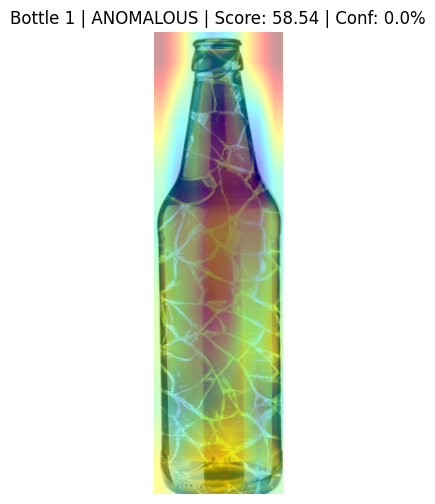

In [ ]:
run_full_anomaly_pipeline(image_path)

In [ ]:
normal_scores = np.array(normal_scores)

In [ ]:
def compute_confidence_percentile(score, normal_scores):
    percentile = np.mean(normal_scores < score) * 100
    return percentile

In [ ]:
def compute_confidence_percentile(score, normal_scores):
    return np.mean(normal_scores < score) * 100

In [ ]:
# Percentile-based confidence (FINAL VERSION)
def compute_confidence_percentile(score, normal_scores):
    """
    Confidence = percentile position of score among normal scores
    """
    normal_scores_np = np.array(normal_scores)
    return float(np.mean(normal_scores_np < score) * 100)

In [ ]:
def draw_defect_markers(image, regions, min_area_ratio=0.0005):
    h, w, _ = image.shape
    img_area = h * w
    marked = image.copy()

    for i, (x, y, bw, bh, area) in enumerate(regions):
        if area / img_area < min_area_ratio:
            continue

        cv2.rectangle(
            marked,
            (x, y),
            (x + bw, y + bh),
            (255, 0, 0),
            2
        )

        cv2.putText(
            marked,
            f"Defect {i+1}",
            (x, max(y - 5, 10)),
            cv2.FONT_HERSHEY_SIMPLEX,
            0.5,
            (255, 0, 0),
            1
        )

    return marked

In [ ]:
def detect_and_analyze_bottles(
    image_path,
    yolo_model,
    backbone,
    normal_feature_bank,
    threshold
):
    img_bgr = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

    results = yolo_model(image_path)
    outputs = []

    ACCEPTED_CLASSES = ["bottle", "vase"]

    for box in results[0].boxes:
        cls_id = int(box.cls[0])
        label = yolo_model.names[cls_id]

        if label not in ACCEPTED_CLASSES:
            continue

        x1, y1, x2, y2 = map(int, box.xyxy[0])
        crop = img_rgb[y1:y2, x1:x2]

        if crop.size == 0:
            continue

        # Feature extraction
        test_features = extract_features(crop)

        # Anomaly map
        anomaly_map = compute_anomaly_map_with_memory(
            test_features, normal_feature_bank
        )

        # Score + decision
        anomaly_score = anomaly_map.max()
        status = "ANOMALOUS" if anomaly_score > threshold else "NORMAL"

        # ✅ FINAL CONFIDENCE (percentile-based)
        confidence = compute_confidence_percentile(
            anomaly_score, normal_scores
        )

        # Defect regions
        regions = extract_defect_regions(anomaly_map)

        # Heatmap overlay
        heatmap_resized = cv2.resize(
            anomaly_map, (crop.shape[1], crop.shape[0])
        )
        heatmap_norm = (
            heatmap_resized - heatmap_resized.min()
        ) / (heatmap_resized.max() - heatmap_resized.min() + 1e-6)

        heatmap_color = cv2.applyColorMap(
            (heatmap_norm * 255).astype(np.uint8),
            cv2.COLORMAP_JET
        )

        overlay = cv2.addWeighted(crop, 0.6, heatmap_color, 0.4, 0)

        outputs.append({
            "bbox": (x1, y1, x2, y2),
            "label": label,
            "score": float(anomaly_score),
            "status": status,
            "confidence": confidence,
            "regions": regions,
            "overlay": overlay
        })

    return img_rgb, outputs

In [ ]:
def draw_defect_markers(
    image,
    regions,
    min_area_ratio=0.01
):
    """
    Draw bounding boxes for defect regions.
    min_area_ratio: minimum defect area relative to image area
    """
    h, w, _ = image.shape
    img_area = h * w

    marked = image.copy()

    for i, (x, y, bw, bh, area) in enumerate(regions):
        if area / img_area < min_area_ratio:
            continue  # ignore tiny noise

        # Draw bounding box
        cv2.rectangle(
            marked,
            (x, y),
            (x + bw, y + bh),
            (255, 0, 0),  # red
            2
        )

        # Label
        cv2.putText(
            marked,
            f"Defect {i+1}",
            (x, max(y - 5, 10)),
            cv2.FONT_HERSHEY_SIMPLEX,
            0.5,
            (255, 0, 0),
            1,
            cv2.LINE_AA
        )

    return marked


image 1/1 /content/istockphoto-667819924-612x612 (1).jpg: 640x448 1 tie, 1 vase, 8.3ms
Speed: 2.8ms preprocess, 8.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 448)

Bottle 1
  Label      : vase
  Status     : ANOMALOUS
  Score      : 58.54
  Confidence : 100.0%
  Defect regions detected: 1


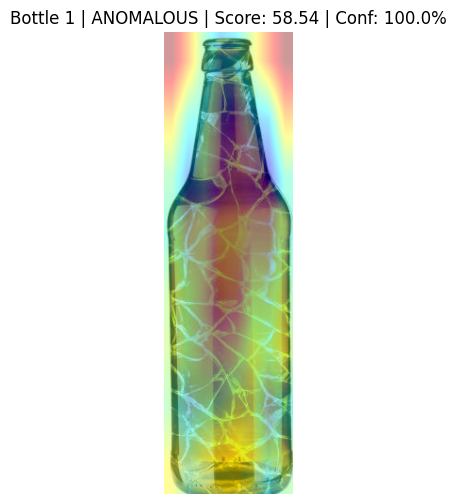

In [ ]:
run_full_anomaly_pipeline(image_path)

In [ ]:
# TEMPORARY TEST: show boxes only
overlay = crop.copy()
overlay = draw_defect_markers(
    overlay,
    regions,
    min_area_ratio=0.001
)


image 1/1 /content/istockphoto-667819924-612x612 (1).jpg: 640x448 1 tie, 1 vase, 6.5ms
Speed: 2.6ms preprocess, 6.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 448)

Bottle 1
  Label      : vase
  Status     : ANOMALOUS
  Score      : 58.54
  Confidence : 100.0%
  Defect regions detected: 1


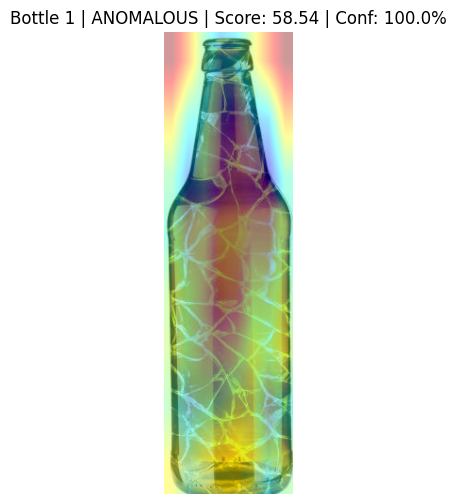

In [ ]:
run_full_anomaly_pipeline(image_path)

In [ ]:
def draw_crack_contours(image, anomaly_map, threshold_ratio=0.6):
    """
    Draw crack-like anomaly contours directly from heatmap
    """
    marked = image.copy()

    thresh_val = threshold_ratio * anomaly_map.max()
    mask = (anomaly_map > thresh_val).astype("uint8") * 255

    contours, _ = cv2.findContours(
        mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
    )

    cv2.drawContours(
        marked,
        contours,
        -1,
        (255, 0, 0),   # RED contours
        2              # thickness
    )

    return marked

In [ ]:
overlay_heatmap = cv2.addWeighted(crop, 0.6, heatmap_color, 0.4, 0)
overlay = draw_defect_markers(overlay_heatmap, regions)

In [ ]:
overlay_heatmap = cv2.addWeighted(crop, 0.6, heatmap_color, 0.4, 0)

overlay_heatmap = cv2.addWeighted(crop, 0.6, heatmap_color, 0.4, 0)

overlay = draw_anomaly_mask(
    overlay_heatmap,
    anomaly_map
)


image 1/1 /content/istockphoto-667819924-612x612 (1).jpg: 640x448 1 tie, 1 vase, 8.6ms
Speed: 3.8ms preprocess, 8.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 448)

Bottle 1
  Label      : vase
  Status     : ANOMALOUS
  Score      : 58.54
  Confidence : 100.0%
  Defect regions detected: 1


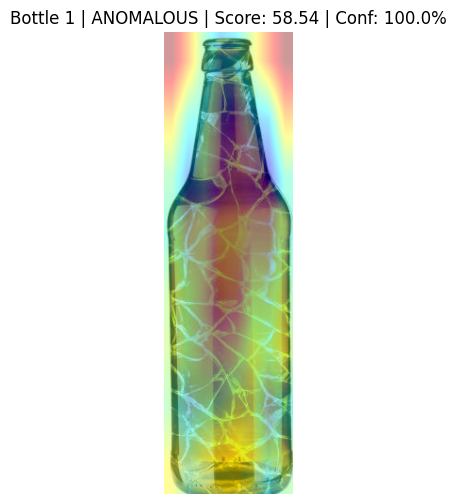

In [ ]:
run_full_anomaly_pipeline(image_path)

In [ ]:
def draw_anomaly_mask(image, anomaly_map, alpha=0.35):
    """
    Overlay a binary anomaly mask instead of contours
    """
    h, w, _ = image.shape
    anomaly_resized = cv2.resize(anomaly_map, (w, h))

    # Normalize
    anomaly_norm = (anomaly_resized - anomaly_resized.min()) / (
        anomaly_resized.max() - anomaly_resized.min() + 1e-6
    )

    # Binary mask (top anomalies)
    mask = (anomaly_norm > 0.6).astype("uint8") * 255

    # Red mask
    red_mask = np.zeros_like(image)
    red_mask[:, :, 0] = mask  # Red channel

    return cv2.addWeighted(red_mask, alpha, image, 1 - alpha, 0)